## MODEL PREPARATION

In [ ]:
# !git clone https://github.com/Changyoon-Lee/big_contest.git

Cloning into 'big_contest'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 360 (delta 0), reused 3 (delta 0), pack-reused 356
Receiving objects: 100% (360/360), 130.76 MiB | 24.60 MiB/s, done.
Resolving deltas: 100% (167/167), done.
Checking out files: 100% (230/230), done.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split
import seaborn as sns
from scipy import stats

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,mean_squared_error, r2_score
from tqdm.notebook import tqdm
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
tf.__version__

from datetime import datetime, timedelta
import pickle
from sklearn.model_selection import cross_validate

import matplotlib as mpl
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING)
from fbprophet import Prophet

fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [7]:
with open('/content/drive/My Drive/빅콘/merged_dataframe.pickle', 'rb') as f:
    data = pickle.load(f)

In [8]:
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d %H:%M:%S', errors='raise')
data['date_month'] = data['date'].dt.month

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


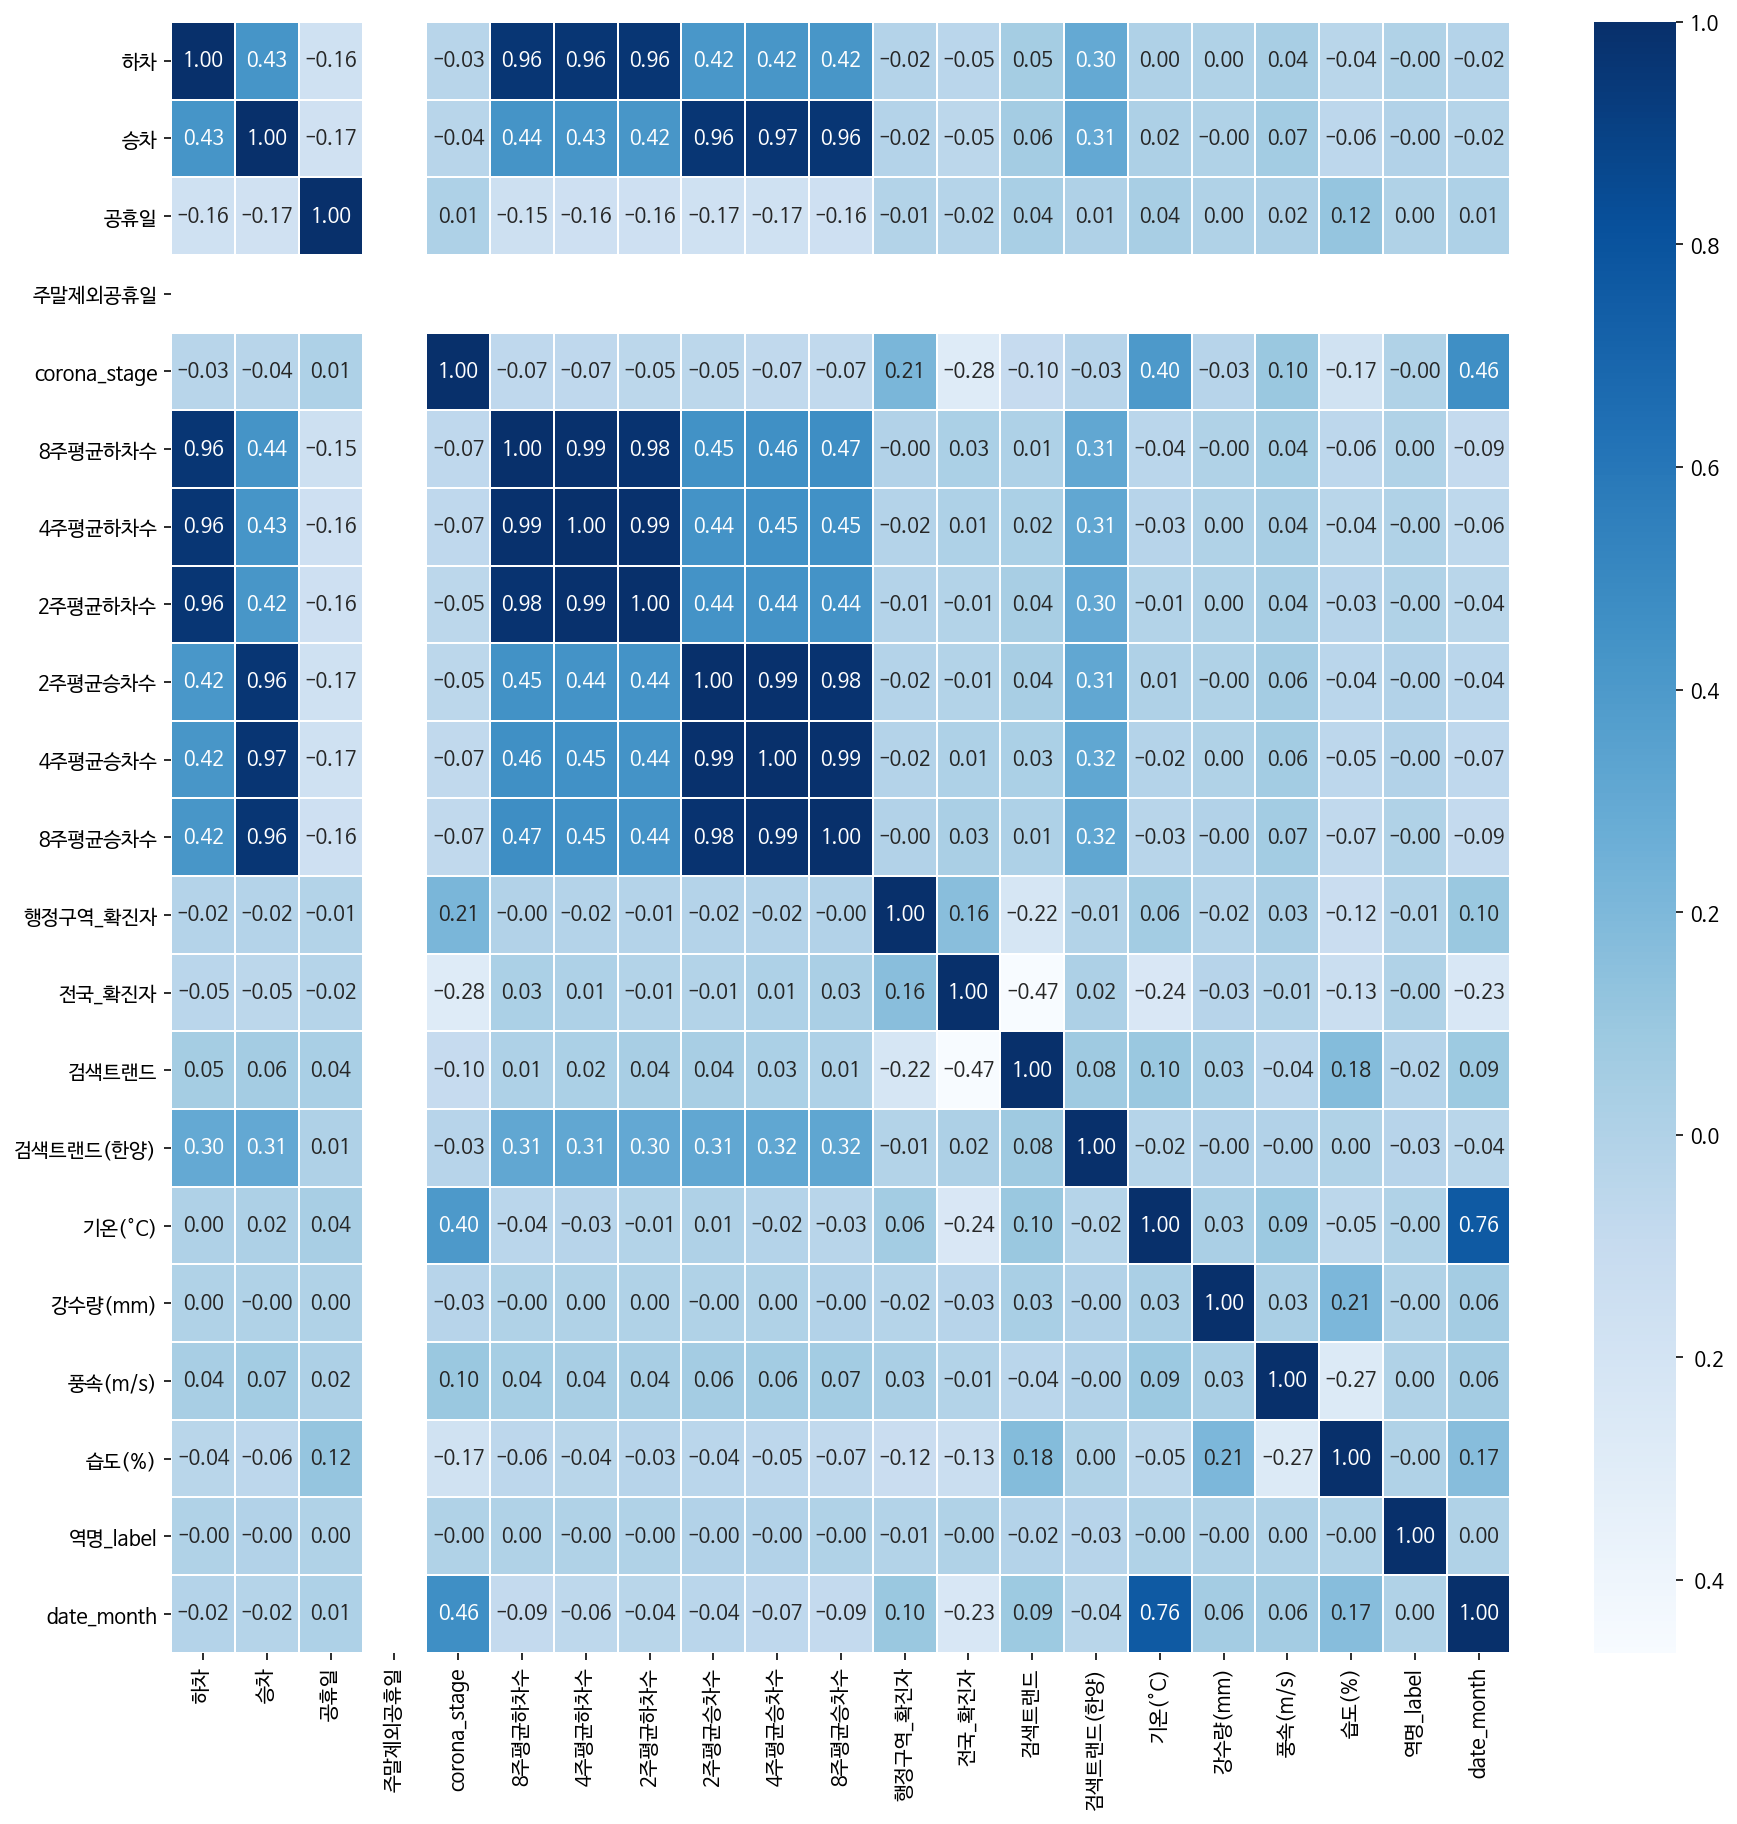

In [ ]:
data.corr

## Regression Model

### 전체로 예측

In [5]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [11]:
def total_linear_regression(data,cols,month): #데이터, 사용될 columns, 예측될 월
  test =  data[data['date_month'] == month]
  train = data[data['date_month'] != month]
  train, test = train[cols],test[cols]
  y_train, X_train = train['하차'] , train.drop('하차',axis=1)
  y_test, X_test = test['하차'] , test.drop('하차',axis=1)

  lin_reg = LinearRegression()
  X_train_ready = df_pipeline.fit_transform(X_train)
  lin_reg.fit(X_train_ready, y_train)
  X_test_ready = df_pipeline.fit_transform(X_test)

  train_score = round(lin_reg.score(X_train_ready,y_train),4)
  test_score = round(lin_reg.score(X_test_ready,y_test),4)
  print('train: {}'.format(train_score))
  print('test: {}'.format(test_score))

In [12]:
data.columns

Index(['역명', 'date', '시간', '하차', '승차', '요일', '공휴일', '주말제외공휴일', 'corona_stage',
       '8주평균하차수', '4주평균하차수', '2주평균하차수', '2주평균승차수', '4주평균승차수', '8주평균승차수',
       '행정구역_확진자', '전국_확진자', '검색트랜드', '검색트랜드(한양)', '기온(°C)', '강수량(mm)',
       '풍속(m/s)', '습도(%)', '지+버승차', '지+버하차', '역명_label', 'date_month'],
      dtype='object')

In [15]:
numeric_columns = ['공휴일','corona_stage','8주평균하차수','행정구역_확진자','전국_확진자','기온(°C)','강수량(mm)','풍속(m/s)', '습도(%)']
cgr_columns = ['요일','시간']
numeric_pipeline = Pipeline([
                             ('imputer', SimpleImputer()),
                             ('scaler', StandardScaler()
                             )])
cgr_pipeline = Pipeline([
                         ('onehot', OneHotEncoder())
                         ])
df_pipeline = ColumnTransformer([
                                 ('num_pipeline', numeric_pipeline, numeric_columns),
                                 ('cgr_pipeline', cgr_pipeline, cgr_columns)
])
cols = numeric_columns + cgr_columns + ['하차']
print('사용된 feature:전체 feature')
total_linear_regression(data,cols,5)

사용된 feature:전체 feature
train: 0.9427
test: 0.9041


In [ ]:
print('사용된 feature: 8주평균하차수')
numeric_columns = ['8주평균하차수']
df_pipeline = ColumnTransformer([
                                 ('num_pipeline', numeric_pipeline, numeric_columns)
])
cols = numeric_columns + ['하차']
total_linear_regression(data,cols,5)

사용된 feature: 8주평균하차수
train: 0.9348
test: 0.9181


### 역마다 예측

In [ ]:
def station_linear_regression(data,cols,days): #데이터, 사용될 column, 예측될 월의 요일수
  score_train, score_test = [],[]
  num = len(set(data['역명_label']))
  for i in tqdm(range(num)):
    prac = data[data['역명_label']==i]  
    prac = prac[cols]
    y = prac['하차']
    X = prac.drop('하차',axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=days*20,shuffle=False)
    X_train_ready = df_pipeline.fit_transform(X_train)
    lin_reg = LinearRegression()
    lin_reg.fit(X_train_ready, y_train)
    score_train.append(lin_reg.score(X_train_ready, y_train))
    X_test_ready = df_pipeline.fit_transform(X_test)
    score_test.append(lin_reg.score(X_test_ready, y_test))
  train_score = round(np.mean(score_train),4)
  test_score = round(np.mean(score_test),4)
  print('train: {}'.format(train_score))
  print('test: {}'.format(test_score))

In [ ]:
print('사용된 feature:전체 feature')
numeric_columns = ['공휴일', 'corona_stage','8주평균하차수','행정구역_확진자', '전국_확진자', '기온(°C)', '강수량(mm)','풍속(m/s)', '습도(%)']
cgr_columns = ['요일','시간']
numeric_pipeline = Pipeline([
                             ('scaler', StandardScaler()
                             )])
cgr_pipeline = Pipeline([
                         ('onehot', OneHotEncoder())
                         ])
df_pipeline = ColumnTransformer([
                                 ('num_pipeline', numeric_pipeline, numeric_columns),
                                 ('cgr_pipeline', cgr_pipeline, cgr_columns)
])
cols = numeric_columns + cgr_columns + ['하차']
station_linear_regression(data,cols,31)

사용된 feature:전체 feature



train: 0.9355
test: 0.823


In [ ]:
print('사용된 feature: 8주평균하차수')
numeric_columns = ['4주평균하차수']
numeric_pipeline = Pipeline([
                             ('scaler', StandardScaler()
                             )])
df_pipeline = ColumnTransformer([
                                 ('num_pipeline', numeric_pipeline, numeric_columns)
])
cols = numeric_columns + ['하차']
station_linear_regression(data,cols,31)

사용된 feature: 8주평균하차수



train: 0.9119
test: 0.8517


# Random Forest Regressor
(0.9702619202201322, 0.9025051341560678)
- 시간라벨 X : train: 0.970, test: 0.902
- 시간라벨 O : train: 0.972, test: 0.904

In [ ]:
numeric_columns = ['공휴일', 'corona_stage','8주평균하차수','행정구역_확진자', '전국_확진자', '기온(°C)', '강수량(mm)','풍속(m/s)', '습도(%)']
cgr_columns = ['요일','시간']
numeric_pipeline = Pipeline([
                             ('scaler', StandardScaler()
                             )])
cgr_pipeline = Pipeline([
                         ('onehot', OneHotEncoder())
                         ])
df_pipeline = ColumnTransformer([
                                 ('num_pipeline', numeric_pipeline, numeric_columns),
                                 ('cgr_pipeline', cgr_pipeline, cgr_columns)
])
cols = numeric_columns + cgr_columns + ['하차']

In [ ]:
score_train, score_test = [],[]
days = 31
num = len(set(data['역명_label']))
for i in tqdm(range(num)):
  prac = data[data['역명_label']==i]  
  prac = prac[cols]
  y = prac['하차']
  X = prac.drop('하차',axis=1)

  X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=days*20,shuffle=False)
  X_train_ready = df_pipeline.fit_transform(X_train)
  forest = RandomForestRegressor(max_depth=5)
  forest.fit(X_train_ready, y_train)
  score_train.append(forest.score(X_train_ready, y_train))
  X_test_ready = df_pipeline.fit_transform(X_test)
  score_test.append(forest.score(X_test_ready, y_test))
np.mean(score_train),np.mean(score_test) #8

(0.9659002239377268, 0.7989989567175775)

In [ ]:
numeric_columns =['8주평균하차수']
numeric_pipeline = Pipeline([
                             ('scaler', StandardScaler()
                             )])
df_pipeline = ColumnTransformer([
                                 ('num_pipeline', numeric_pipeline, numeric_columns)
])

In [ ]:
score_train, score_test = [],[]
days = 31
num = len(set(data['역명_label']))
for i in tqdm(range(num)):
  prac = data[data['역명_label']==i]  
  prac = prac[cols]
  y = prac['하차']
  X = prac.drop('하차',axis=1)

  X_train, X_test, y_train, y_test = train_test_split(X, y,shuffle=False)
  X_train_ready = df_pipeline.fit_transform(X_train)
  forest = RandomForestRegressor(max_depth=5)
  forest.fit(X_train_ready, y_train)
  score_train.append(forest.score(X_train_ready, y_train))
  X_test_ready = df_pipeline.fit_transform(X_test)
  score_test.append(forest.score(X_test_ready, y_test))
np.mean(score_train),np.mean(score_test) #5

(0.9268663741984531, 0.8908440026506088)

In [ ]:
np.mean(score_train),np.mean(score_test) #5

(0.9702452569623503, 0.9020317266946408)

# Facebook Prophet

In [87]:
with open('/content/drive/My Drive/빅콘/data_timeseries_all.pickle', 'rb') as f:
    time_series_all = pickle.load(f)

In [89]:
num = len(set(time_series_all['역명_label']))
score = []
for i in tqdm(range(num)):
  subway = time_series_all[time_series_all['역명_label']==i].reset_index(drop=True)
  subway = subway[['new_date','하차']]
  subway.columns = ['ds','y']
  X_train = subway[:2160] # 5월 기준
  X_test = subway[2160:]
  prophet = Prophet()
  prophet.fit(X_train)
  days = 31 # 예측월의 일수
  future = prophet.make_future_dataframe(periods=days*24,freq='H')
  forecast = prophet.predict(future)
  forecast_ = forecast[['ds','yhat']].iloc[-len(X_test):]
  y_hat = [forecast_['yhat'].iloc[i] for i in range(len(forecast_)) if forecast_['ds'].iloc[i].strftime('%H') not in ['01','02','03','04']]
  X_test_new = [X_test['y'].iloc[i] for i in range(len(X_test)) if X_test['ds'].iloc[i].strftime('%H') not in ['01','02','03','04']]
  score.append(r2_score(X_test_new, y_hat))
prophet_score = round(np.mean(score),4)
print('Prophet score:{}'.format(prophet_score))


Prophet score:0.5939


In [90]:
# y_2_axis = np.arange(len(X_train), len(X_train) + len(y_hat))

# plt.figure(figsize=(50,10))
# plt.plot(y_2_axis, y_hat, '-o', color='red', label='predicted') #x_test 예측값 그래프로 표현
# plt.plot(y_2_axis, X_test_new, '-o', color='purple', alpha=0.3, label='actual') #y_test 실제값 그래프로 표현 
# plt.legend(fontsize=20)
# plt.show()

# LSTM

In [24]:
with open('/content/drive/My Drive/빅콘/data_timeseries.pickle', 'rb') as f:
    time_series = pickle.load(f)

In [133]:
subway = time_series[time_series['역명_label']==0]

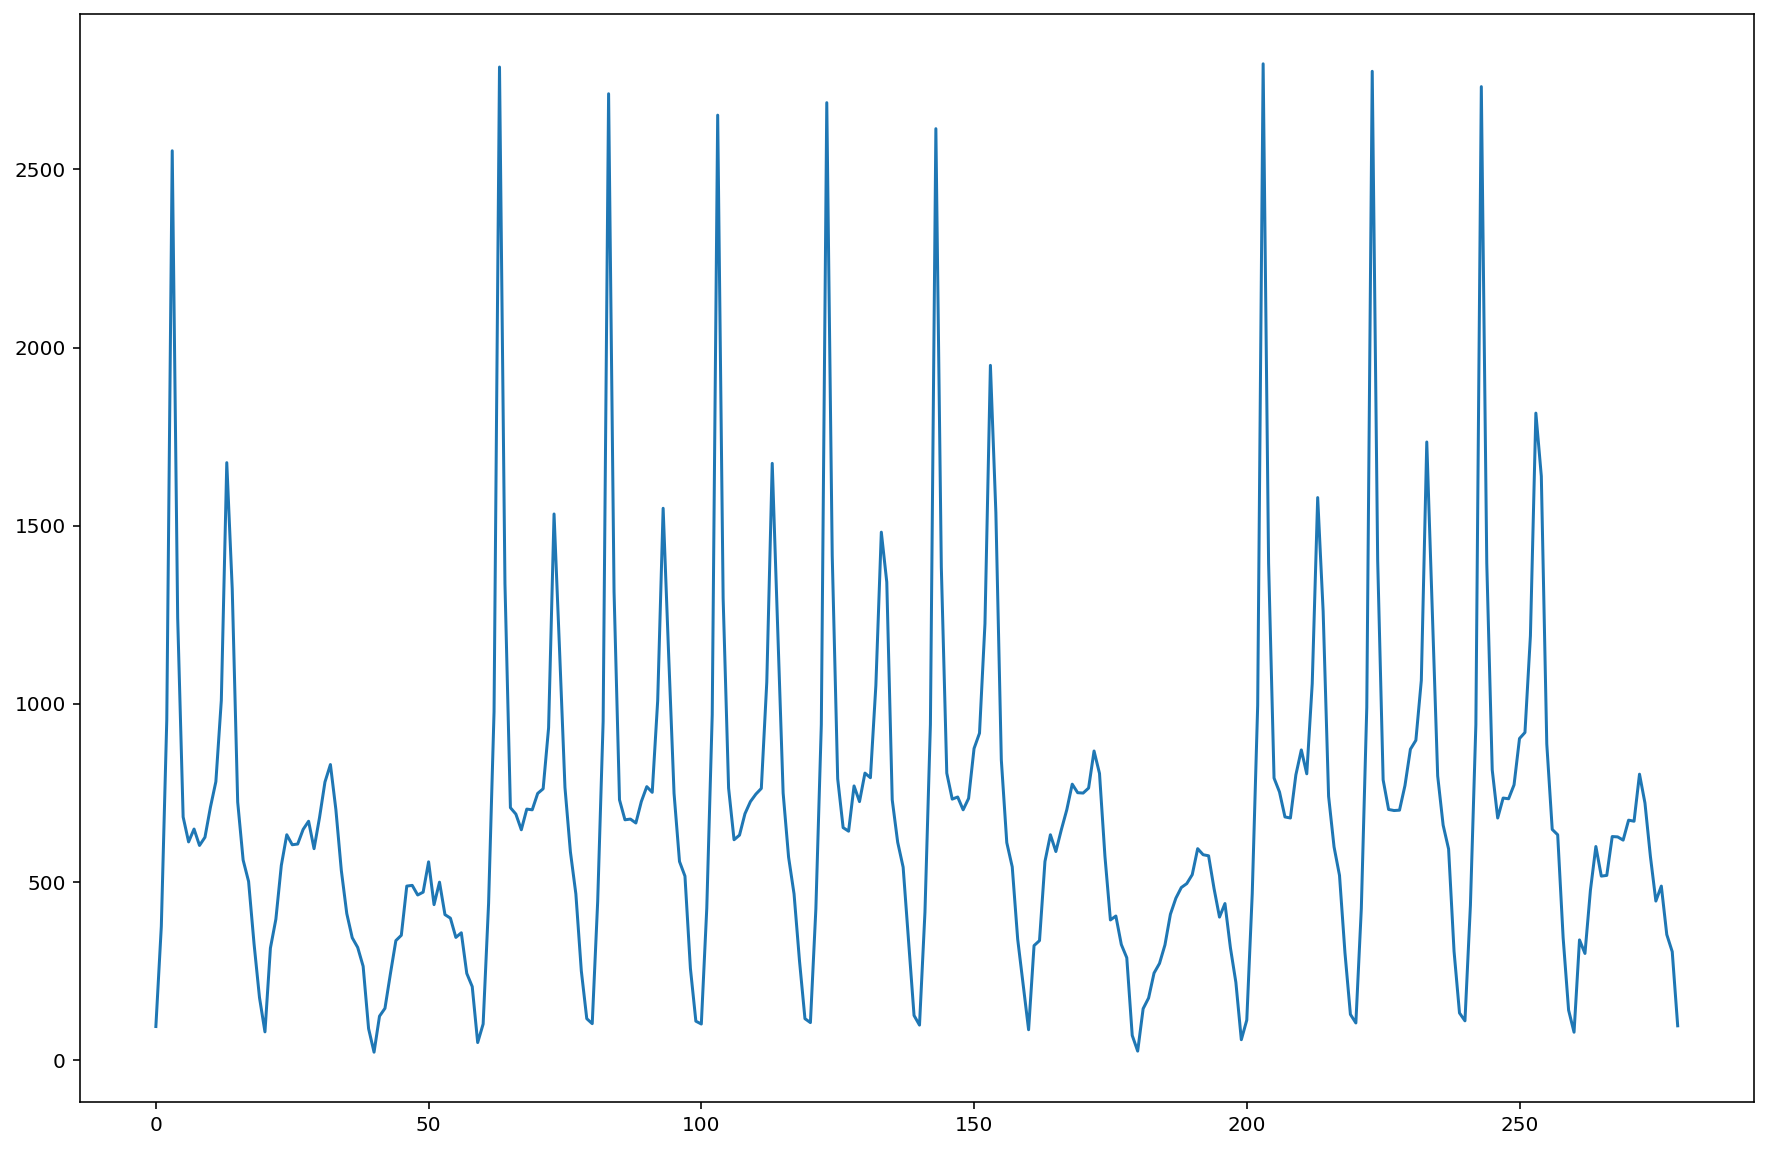

In [89]:
plt.figure(figsize=(15,10))
plt.plot(np.arange(len(subway[1520:1800])),subway['하차'][1520:1800])

In [ ]:
  X_ = np.array(subway['하차'][:1800])
X_ = (X_-X_.mean(axis=0))/X_.std(axis=0)
  X = np.array([[[X_[i+j]] for j in range(140)] for i in range(len(X_)-140)])
  y = np.array([[X_[i+140]] for i in range(len(X_)-140)])
  X_test = X_[-140:].reshape(1,-1,1)

  model = tf.keras.Sequential()
  model.add(layers.LSTM(140, return_sequences=True))
  model.add(layers.Dropout(0.2)) # 규제 (레이어간)
  model.add(layers.LSTM(20, return_sequences=True))
  model.add(layers.Dropout(0.2))
  model.add(layers.LSTM(5))
  model.add(layers.Dense(1))
  model.compile(optimizer='adam',loss='mse')
  model.fit(X, y, epochs=20, verbose=0)

  y_hat = model.predict(X_test)
  y_predicted.append(y_hat[0][0])
  X_ = np.append(X_,y_hat[0])
  X_ = X_[1:]

In [ ]:
X_ = np.array(subway['하차'][:1800])
X_ = (X_-X_.mean(axis=0))/X_.std(axis=0)
y_predicted = []
for _ in tqdm(range(620)):
  X = np.array([[[X_[i+j]] for j in range(140)] for i in range(len(X_)-140)])
  y = np.array([[X_[i+140]] for i in range(len(X_)-140)])
  X_test = X_[-140:].reshape(1,-1,1)

  model = tf.keras.Sequential()
  model.add(layers.LSTM(140, return_sequences=True))
  model.add(layers.Dropout(0.2)) # 규제 (레이어간)
  model.add(layers.LSTM(20, return_sequences=True))
  model.add(layers.Dropout(0.2))
  model.add(layers.LSTM(5))
  model.add(layers.Dense(1))
  model.compile(optimizer='adam',loss='mse')
  model.fit(X, y, epochs=20, verbose=0)

  y_hat = model.predict(X_test)
  y_predicted.append(y_hat[0][0])
  X_ = np.append(X_,y_hat[0])
  X_ = X_[1:]

In [ ]:
len(subway[1800:]),len(y_predicted)

In [ ]:
r2_score(subway[1800:], y_predicted)

array([-0.45195316, -0.37312921, -0.62836865, -0.71845317, -1.10881938])

In [ ]:
score_list = []

In [ ]:
for i in tqdm(range(175)):
  subway = prac[prac['역명_label']==i] 
  subway = np.array(subway['하차'])
  subway = (subway-subway.mean(axis=0))/subway.std(axis=0)
  time_step = 20 #24시간 기준
  days = 31 #마지막월
  X = np.array([[[subway[i+j]] for j in range(time_step)] for i in range(len(subway)-time_step)])
  y = np.array([[subway[i+time_step]] for i in range(len(subway)-time_step)])
  x_train, x_test, y_train, y_test =  train_test_split(X, y, shuffle=False, test_size=days*time_step)
  model = tf.keras.Sequential()
  model.add(layers.LSTM(20, return_sequences=True))
  model.add(layers.Dropout(0.2)) # 규제 (레이어간)
  model.add(layers.LSTM(10, return_sequences=True))
  model.add(layers.Dropout(0.2))
  model.add(layers.LSTM(5, recurrent_dropout=0.2))
  model.add(layers.Dense(1))

  model.compile(optimizer=tf.keras.optimizers.RMSprop(),
                loss='mse')
  model.fit(x_train, y_train, epochs=100, verbose=0)
  score_list.append(model.evaluate(x_test, y_test, batch_size = 30))
np.mean(score_list)

21/21 [==============================] - 0s 11ms/step - loss: 0.2734
